In [1]:
## import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from time import time

from imblearn.ensemble import BalanceCascade 

/usr/local/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
def get_subdata(data, size=10000):
    column = ['KORREKTUR']
    if data.KORREKTUR.dtype != np.float32:
        korrektur_vals = data[column].apply(lambda x: x.str.replace(',', '.'))[column[0]]
    else:
        korrektur_vals = data[column[0]]
    korrektur_vals = pd.to_numeric(korrektur_vals, downcast='float', errors='ignore')

    korrektur_df = pd.concat([data.ID, korrektur_vals], axis=1)

    target =  korrektur_df.drop_duplicates(subset=['ID'])[['ID', 'KORREKTUR']].reset_index(drop=True)
    N = len(target)

    ratio = np.sign(target.KORREKTUR).mean()
    n_samples = int(ratio * size)
    indices1 = np.random.choice(target[target.KORREKTUR>0].ID, size = n_samples, replace=False)
    indices0 = np.random.choice(target[target.KORREKTUR==0].ID, size = size - n_samples, replace=False)

    indices = np.append(indices0, indices1)
    return data.set_index('ID').loc[indices].reset_index()

In [3]:
## import data
DATA = pd.read_csv("Data/daten_anonym2/arzta_daten_anonym1.csv", sep=';')
print(DATA.shape)

DATA = get_subdata(DATA, size=100000)
print(DATA.shape)

(1000000, 15)
(331559, 15)


In [4]:
DATA.head()

,ID,KORREKTUR,RECHNUNGSBETRAG,ALTER,GESCHLECHT,VERSICHERUNG,FACHRICHTUNG,NUMMER,NUMMER_KAT,TYP,ANZAHL,FAKTOR,BETRAG,ART,LEISTUNG
0,ID_106318,0,"83,8","64,1983649070293",1,1,1,A_876,AA_13,0.0,1,"1,15","13,41",NaN,C_6
1,ID_221145,0,"110,6","61,2338115321857",0,1,1,NaN,AA_1,NaN,1,0,"1,18",B_2,C_2
2,ID_221145,0,"110,6","61,2338115321857",0,1,1,A_1770,AA_5,0.0,1,"1,8","3,46",NaN,C_17
3,ID_221145,0,"110,6","61,2338115321857",0,1,1,A_2004,AA_6,0.0,1,"2,3","32,17",NaN,C_1
4,ID_52468,0,"205,13","30,7308350304003",0,1,1,A_20,AA_8,0.0,1,"2,3","6,03",NaN,C_1


* **Same** for each ID: *RECHNUNGSBETRAG, ALTER, GESCHLECHT, VERSICHERUNG == FACHRICHTUNG* (4)
* **Diff** for each ID: *NUMMER, NUMMER_KAT, ANZAHL, FAKTOR, BETRAG, ART, TYP, LEISTUNG* (8)

In [5]:
%%time 
## transfrom str type to float type
columns_comma = ['RECHNUNGSBETRAG', 'FAKTOR', 'BETRAG', 'ALTER', 'KORREKTUR'] 
DATA[columns_comma] = DATA[columns_comma].apply(lambda x: x.str.replace(',', '.'))
for column in columns_comma:
    DATA[column] = pd.to_numeric(DATA[column], downcast='float')

CPU times: user 2.63 s, sys: 146 ms, total: 2.78 s
Wall time: 2.78 s


In [6]:
%%time
## construct target column
target = DATA.groupby(['ID'])['KORREKTUR'].apply(lambda dt: int(np.sign(dt).values[0])).to_frame(name='target')
DATA = DATA.merge(target, on='ID', how='inner')

CPU times: user 13 s, sys: 83 ms, total: 13.1 s
Wall time: 13.1 s


In [7]:
## DATA must be sorted by Id
current_id = ''
indices = []

for i, Id in enumerate(DATA.ID):
    if Id != current_id:
        if i > 0: 
            indices.append(current_index)
        current_id = Id
        current_index = [i]
    else:
        current_index.append(i)
        
indices.append(current_index)

### BETRAG, ANZAHL: mean, std, min, max, median

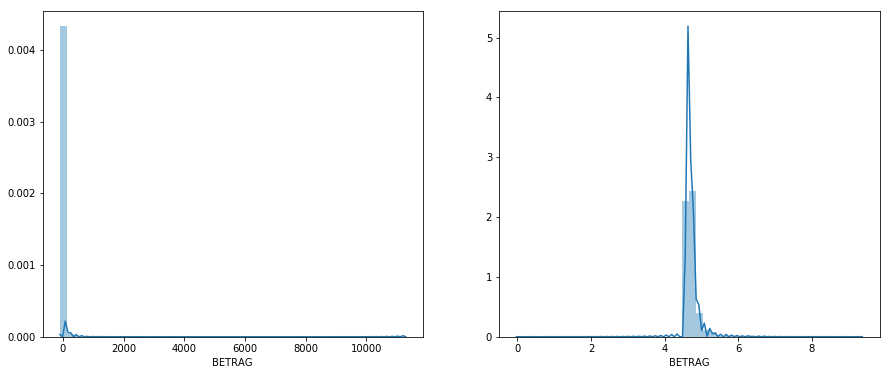

In [8]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
sns.distplot(DATA.BETRAG)
plt.subplot(122)
sns.distplot(np.log(DATA.BETRAG  - DATA.BETRAG.min() + 1));

In [9]:
# BETRAG / ANZAHL (prices for one treatment) 
vals = DATA.BETRAG / DATA.ANZAHL
DATA.BETRAG = np.log(vals - np.min(vals, 0) +  1)

In [10]:
%%time
# construct mean and std values for each ID
betrag_mean = DATA.groupby(['ID'])['BETRAG'].mean()
betrag_std = DATA.groupby(['ID'])['BETRAG'].std().fillna(0)
betrag_min = DATA.groupby(['ID'])['BETRAG'].min()
betrag_max = DATA.groupby(['ID'])['BETRAG'].max()
betrag_median = DATA.groupby(['ID'])['BETRAG'].median()

betrag_all = pd.concat([betrag_mean, betrag_std, betrag_min, betrag_max, betrag_median], axis=1, keys=
          ['BETRAG_mean', 'BETRAG_std', 'BETRAG_min', 'BETRAG_max', 'BETRAG_median']).reset_index()

CPU times: user 1.69 s, sys: 79.9 ms, total: 1.77 s
Wall time: 1.77 s


In [11]:
betrag_all.head()

,ID,BETRAG_mean,BETRAG_std,BETRAG_min,BETRAG_max,BETRAG_median
0,ID_1,3.377132,0.000000,3.377132,3.377132,3.377132
1,ID_100000,3.164229,0.396273,2.852824,3.701713,3.051189
2,ID_100007,3.488443,0.230753,3.325276,3.651610,3.488443
3,ID_100008,3.501847,0.000000,3.501847,3.501847,3.501847
4,ID_10001,3.144429,0.349895,2.838298,3.897045,2.983997


In [12]:
betrag_data = []
start = time()
ticks = np.linspace(2, 6, 100)
ids = DATA.ID.unique()
for i, Id in enumerate(ids):
    indices[i]
    betrag_data.append(np.histogram(DATA.iloc[indices[i]]['BETRAG'], ticks)[0])
    if i % 3000 == 0: 
        print(i, 'Done', np.round(i / len(ids) * 100, 2) , '% time:', time() - start)    

betrag_data = pd.DataFrame(betrag_data, columns = ['betrag' + str(np.round(val, 2)) for val in ticks[:-1]])
betrag_data = pd.concat([pd.Series(ids, name='ID'), betrag_data], axis=1)

0 Done 0.0 % time: 0.1126861572265625
3000 Done 3.0 % time: 2.0521469116210938
6000 Done 6.0 % time: 3.9958760738372803
9000 Done 9.0 % time: 5.955365896224976
12000 Done 12.0 % time: 7.898069143295288
15000 Done 15.0 % time: 9.834380149841309
18000 Done 18.0 % time: 11.981970071792603
21000 Done 21.0 % time: 14.10054898262024
24000 Done 24.0 % time: 16.351908922195435
27000 Done 27.0 % time: 18.38751220703125
30000 Done 30.0 % time: 20.3259220123291
33000 Done 33.0 % time: 22.58640694618225
36000 Done 36.0 % time: 24.854125022888184
39000 Done 39.0 % time: 27.169183015823364
42000 Done 42.0 % time: 29.380154848098755
45000 Done 45.0 % time: 31.64557123184204
48000 Done 48.0 % time: 34.077167987823486
51000 Done 51.0 % time: 36.3307569026947
54000 Done 54.0 % time: 38.505675077438354
57000 Done 57.0 % time: 40.568442821502686
60000 Done 60.0 % time: 42.98056697845459
63000 Done 63.0 % time: 45.23236608505249
66000 Done 66.0 % time: 47.50551104545593
69000 Done 69.0 % time: 49.664793014

In [13]:
betrag_data.head()

,ID,betrag2.0,betrag2.04,betrag2.08,betrag2.12,betrag2.16,betrag2.2,betrag2.24,betrag2.28,betrag2.32,...,betrag5.6,betrag5.64,betrag5.68,betrag5.72,betrag5.76,betrag5.8,betrag5.84,betrag5.88,betrag5.92,betrag5.96
0,ID_106318,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ID_221145,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ID_52468,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ID_138584,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ID_178243,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### FAKTOR: mean, std, min, max, median

In [17]:
%%time
# construct mean and std values for each ID
faktor_mean = DATA.groupby(['ID'])['FAKTOR'].mean()
faktor_std = DATA.groupby(['ID'])['FAKTOR'].std().fillna(0)
faktor_min = DATA.groupby(['ID'])['FAKTOR'].min()
faktor_max = DATA.groupby(['ID'])['FAKTOR'].max()
faktor_median = DATA.groupby(['ID'])['FAKTOR'].median()

faktor_all = pd.concat([faktor_mean, faktor_std, faktor_min, faktor_max, faktor_median], axis=1, keys=
          ['FAKTOR_mean', 'FAKTOR_std', 'FAKTOR_min', 'FAKTOR_max', 'FAKTOR_median']).reset_index()

CPU times: user 1.66 s, sys: 51.8 ms, total: 1.72 s
Wall time: 1.71 s


In [18]:
faktor_all.head()

,ID,FAKTOR_mean,FAKTOR_std,FAKTOR_min,FAKTOR_max,FAKTOR_median
0,ID_1,2.300,0.00,2.30,2.30,2.30
1,ID_100000,0.575,1.15,0.00,2.30,0.00
2,ID_100007,2.300,0.00,2.30,2.30,2.30
3,ID_100008,2.300,0.00,2.30,2.30,2.30
4,ID_10001,1.150,0.00,1.15,1.15,1.15


### TYP: mean, std, min, max, median

In [19]:
%%time
# construct mean and std values for each ID
DATA.TYP.fillna(-1, inplace=True)
typ_mean = DATA.groupby(['ID'])['TYP'].mean()
typ_std = DATA.groupby(['ID'])['TYP'].std().fillna(0)
typ_min = DATA.groupby(['ID'])['TYP'].min()
typ_max = DATA.groupby(['ID'])['TYP'].max()
typ_median = DATA.groupby(['ID'])['TYP'].median()

typ_all = pd.concat([typ_mean, typ_std, typ_min, typ_max, typ_median], axis=1, keys=
          ['TYP_mean', 'TYP_std', 'TYP_min', 'TYP_max', 'TYP_median']).reset_index()

CPU times: user 1.64 s, sys: 43.1 ms, total: 1.68 s
Wall time: 1.68 s


In [20]:
typ_all.head()

,ID,TYP_mean,TYP_std,TYP_min,TYP_max,TYP_median
0,ID_1,0.00,0.0,0.0,0.0,0.0
1,ID_100000,-0.75,0.5,-1.0,0.0,-1.0
2,ID_100007,0.00,0.0,0.0,0.0,0.0
3,ID_100008,0.00,0.0,0.0,0.0,0.0
4,ID_10001,0.00,0.0,0.0,0.0,0.0


### NUMMER, NUMMER_KAT, LEISTUNG, ART. Encode all treatments and their categories

In [21]:
%%time

nummer_list = []

ids = DATA.ID.unique()
start = time()
for i, Id in enumerate(ids):
    nummer_counter = DATA.iloc[indices[i]]['NUMMER'].value_counts()
    nummer_list.append(dict(nummer_counter))
    if i % 3000 == 0: 
        print(i, 'Done', np.round(i / len(ids) * 100, 2) , '% time:', time() - start)        

0 Done 0.0 % time: 0.002817869186401367
3000 Done 3.0 % time: 4.385588884353638
6000 Done 6.0 % time: 8.639527797698975
9000 Done 9.0 % time: 13.339801788330078
12000 Done 12.0 % time: 17.2711238861084
15000 Done 15.0 % time: 21.112568855285645
18000 Done 18.0 % time: 25.01653289794922
21000 Done 21.0 % time: 29.006905794143677
24000 Done 24.0 % time: 32.85809302330017
27000 Done 27.0 % time: 36.6914439201355
30000 Done 30.0 % time: 40.54617190361023
33000 Done 33.0 % time: 44.450939893722534
36000 Done 36.0 % time: 48.283238887786865
39000 Done 39.0 % time: 52.2068989276886
42000 Done 42.0 % time: 56.07800602912903
45000 Done 45.0 % time: 59.94103288650513
48000 Done 48.0 % time: 63.83535099029541
51000 Done 51.0 % time: 67.7394859790802
54000 Done 54.0 % time: 71.62924575805664
57000 Done 57.0 % time: 75.56708288192749
60000 Done 60.0 % time: 79.47623181343079
63000 Done 63.0 % time: 83.42923593521118
66000 Done 66.0 % time: 87.29062080383301
69000 Done 69.0 % time: 91.15952205657959

In [22]:
%%time
## Attention: it takes a lot of memory
nummer_df = pd.DataFrame(nummer_list).to_sparse()

CPU times: user 43.6 s, sys: 8.71 s, total: 52.3 s
Wall time: 52.9 s


In [23]:
%%time

nummer_kat_list = []
leistung_list = []
art_list = []

start = time()
ids = DATA.ID.unique()
for i, Id in enumerate(ids):

    nummer_kat_counter = DATA.iloc[indices[i]]['NUMMER_KAT'].value_counts()
    leistung_counter = DATA.iloc[indices[i]]['LEISTUNG'].value_counts()
    art_counter = DATA.iloc[indices[i]]['ART'].value_counts()
    
    nummer_kat_list.append(dict(nummer_kat_counter))
    leistung_list.append(dict(leistung_counter))
    art_list.append(dict(art_counter))
    
    if i % 3000 == 0: 
        print(i, 'Done', np.round(i / len(ids) * 100, 2) , '% time:', time() - start)    

0 Done 0.0 % time: 0.25664305686950684
3000 Done 3.0 % time: 11.501805067062378
6000 Done 6.0 % time: 22.76370620727539
9000 Done 9.0 % time: 33.925174951553345
12000 Done 12.0 % time: 45.319401025772095
15000 Done 15.0 % time: 56.55755400657654
18000 Done 18.0 % time: 68.08613300323486
21000 Done 21.0 % time: 79.56050777435303
24000 Done 24.0 % time: 90.87017798423767
27000 Done 27.0 % time: 102.14948606491089
30000 Done 30.0 % time: 113.45400595664978
33000 Done 33.0 % time: 124.65221500396729
36000 Done 36.0 % time: 135.83514285087585
39000 Done 39.0 % time: 146.98508596420288
42000 Done 42.0 % time: 158.22011590003967
45000 Done 45.0 % time: 169.41063904762268
48000 Done 48.0 % time: 180.65779495239258
51000 Done 51.0 % time: 191.90528678894043
54000 Done 54.0 % time: 203.44812488555908
57000 Done 57.0 % time: 214.69745516777039
60000 Done 60.0 % time: 226.00928688049316
63000 Done 63.0 % time: 237.3789918422699
66000 Done 66.0 % time: 248.81013083457947
69000 Done 69.0 % time: 260

In [24]:
%%time 
nummer_kat_df = pd.DataFrame(nummer_kat_list).to_sparse()
leistung_df = pd.DataFrame(leistung_list).to_sparse()
art_df = pd.DataFrame(art_list).to_sparse()

CPU times: user 2.16 s, sys: 59 ms, total: 2.22 s
Wall time: 2.22 s


## Construct new DataFrame

In [25]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve, roc_curve

def plot_confusion_matrix(prediction, y_test):
    plt.figure(figsize=(15, 6))
    c_matrix = confusion_matrix(y_test, prediction)
    c_matrix_ = np.round(100 * c_matrix / c_matrix.sum(axis=1).reshape(-1, 1))
    plt.subplot(121)
    sns.heatmap(c_matrix, annot=True, fmt="d");
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.subplot(122)
    sns.heatmap(np.asarray(c_matrix_, dtype=int), annot=True, fmt="d")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def get_roc_auc_score(prediction, y_test):
    value = np.round(roc_auc_score(y_test, prediction[:,1]),4)
    print('ROC AUC score:',  value)
    
    return value

def get_pr_auc_score(prediction, y_test):
    value = np.round(average_precision_score(y_test, prediction[:, 1]),4)
    print('PR AUC score:',  value)
    
    return value
    
def plot_curves(prediction, y_test):
    tpr, fpr, _ = roc_curve(y_test, prediction[:,1])
    roc_auc = roc_auc_score(y_test, prediction[:,1])
    
    precision, recall, _ = precision_recall_curve(y_test, prediction[:,1])
    average_precision = average_precision_score(y_test, prediction[:,1])

    plt.figure(figsize=(15, 6))
    plt.subplot(121)
    plt.step(tpr, fpr, color='b', alpha=0.2, where='post')
    plt.fill_between(tpr, fpr, step='post', alpha=0.2, color='b')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class ROC curve: ROC AUC={0:0.2f}'.format(roc_auc))

    plt.subplot(122)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    
def plot_probas(prediction_proba):
    plt.figure(figsize=(14, 4))
    probas = prediction_proba[:, 1]
    ax = sns.distplot(probas)
    proba_mean = probas.mean()
    plt.plot([probas.mean()] * 2, ax.get_ylim(), label='Mean of probabilites')
    plt.legend(fontsize=16)

In [26]:
data = DATA.drop_duplicates(subset=['ID'])[['ID', 'RECHNUNGSBETRAG', 'ALTER', 'GESCHLECHT', 'VERSICHERUNG', 'target']].reset_index(drop=True)

data = data.merge(betrag_all, on='ID', how='inner')
data = data.merge(betrag_data, on='ID', how='inner')
data = data.merge(typ_all, on='ID', how='inner')
data = data.merge(faktor_all, on='ID', how='inner')

data.head()

,ID,RECHNUNGSBETRAG,ALTER,GESCHLECHT,VERSICHERUNG,target,BETRAG_mean,BETRAG_std,BETRAG_min,BETRAG_max,...,TYP_mean,TYP_std,TYP_min,TYP_max,TYP_median,FAKTOR_mean,FAKTOR_std,FAKTOR_min,FAKTOR_max,FAKTOR_median
0,ID_106318,83.800003,64.198364,1,1,0,3.417617,0.000000,3.417617,3.417617,...,0.000000,0.00000,0.0,0.0,0.0,1.150000,0.000000,1.15,1.15,1.15
1,ID_221145,110.599998,61.233810,0,1,0,3.274940,0.541958,2.905078,3.897045,...,-0.333333,0.57735,-1.0,0.0,0.0,1.366667,1.209683,0.00,2.30,1.80
2,ID_52468,205.130005,30.730835,0,1,0,3.410474,0.250788,3.140554,3.718843,...,0.000000,0.00000,0.0,0.0,0.0,2.175000,0.250000,1.80,2.30,2.30
3,ID_138584,280.750000,35.568867,0,1,0,3.663232,0.146884,3.501847,3.789102,...,0.000000,0.00000,0.0,0.0,0.0,2.266667,1.250333,1.00,3.50,2.30
4,ID_178243,293.720001,76.825798,1,1,0,3.137124,0.350948,2.983997,4.048591,...,0.000000,0.00000,0.0,0.0,0.0,1.350000,0.416083,1.15,2.30,1.15


In [27]:
%%time 
nummer_df.fillna(0, inplace=True)
nummer_kat_df.fillna(0, inplace=True)
leistung_df.fillna(0, inplace=True)
art_df.fillna(0, inplace=True)

data = pd.concat([data, nummer_df], axis=1)
data = pd.concat([data, nummer_kat_df], axis=1)
data = pd.concat([data, leistung_df], axis=1)
data = pd.concat([data, art_df], axis=1)

CPU times: user 890 ms, sys: 257 ms, total: 1.15 s
Wall time: 1.14 s


In [28]:
## train test split of data
X_train, X_test, y_train, y_test = train_test_split(data.drop(['ID', 'target'], axis=1), data.target)

ROC AUC score: 0.8345
PR AUC score: 0.0994
CPU times: user 24.8 s, sys: 7.02 s, total: 31.8 s
Wall time: 23.8 s


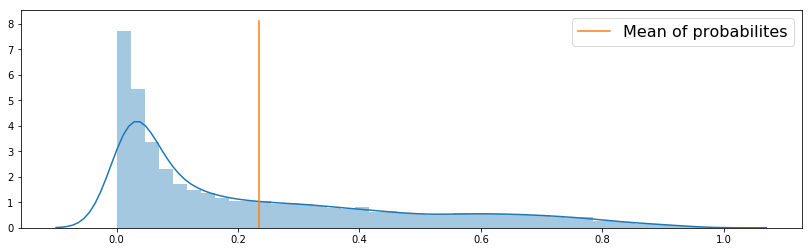

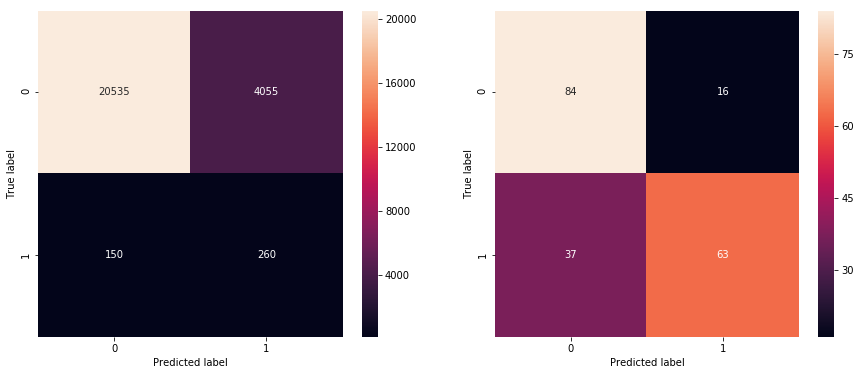

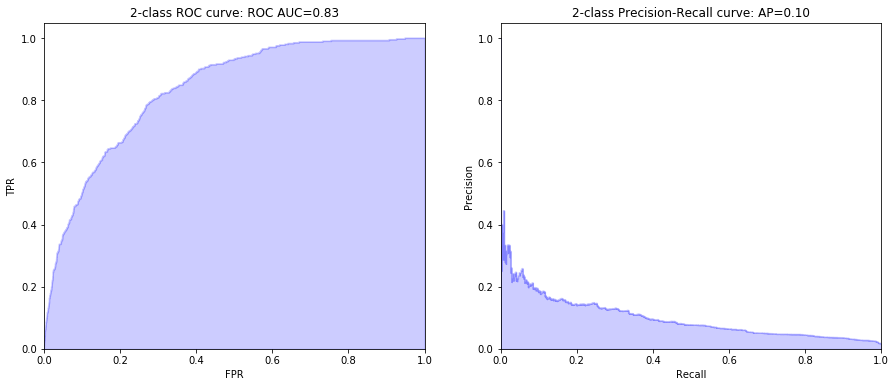

In [29]:
%%time 
model = LGBMClassifier(class_weight={0: y_train.mean(), 1: 1 - y_train.mean()})
model.fit(X_train, y_train)

prediction = model.predict(X_test)
prediction_proba = model.predict_proba(X_test)
plot_probas(prediction_proba)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

ROC AUC score: 0.843
PR AUC score: 0.1077
CPU times: user 7min 46s, sys: 8.63 s, total: 7min 55s
Wall time: 7min 56s


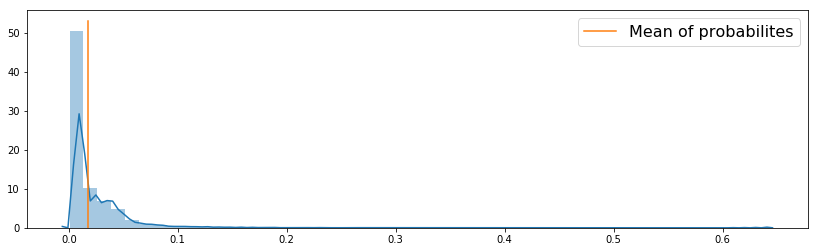

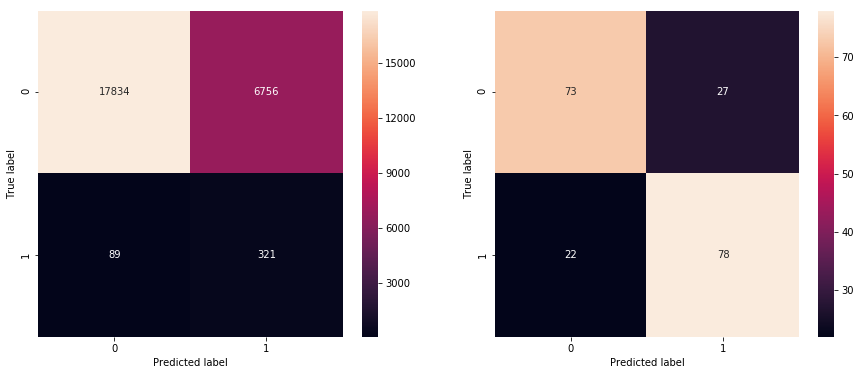

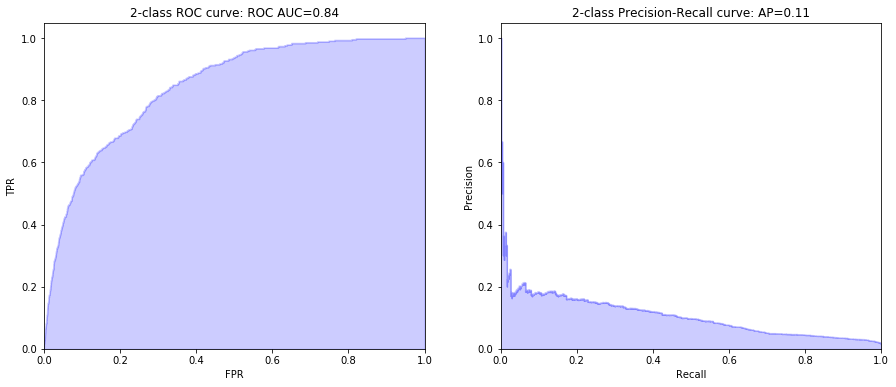

In [30]:
%%time 
model = XGBClassifier()
model.fit(X_train, y_train)

#prediction = model.predict(X_test)
prediction_proba = model.predict_proba(X_test)
plot_probas(prediction_proba)
prediction = prediction_proba[:, 1] > prediction_proba[:, 1].mean()

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

ROC AUC score: 0.7563
PR AUC score: 0.0789
CPU times: user 16.9 s, sys: 2.03 s, total: 19 s
Wall time: 19 s


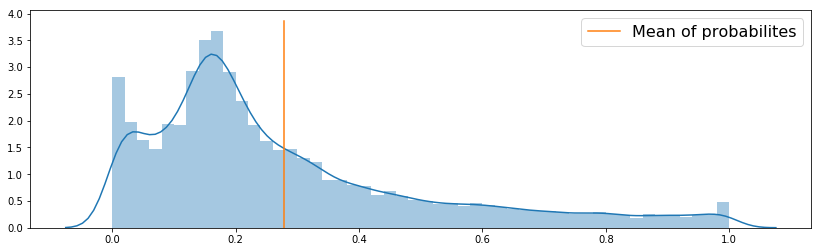

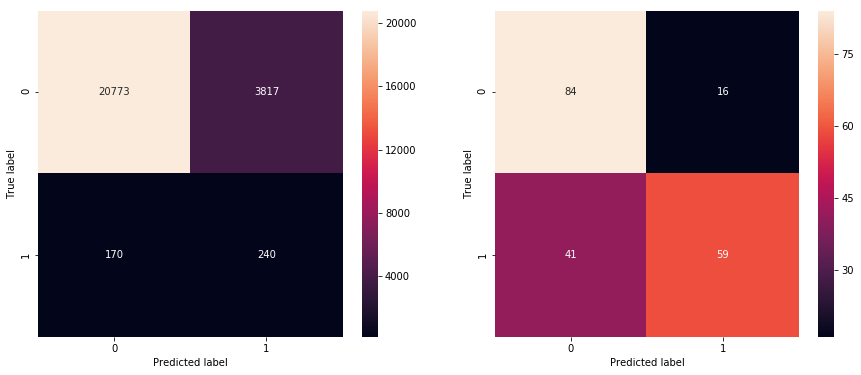

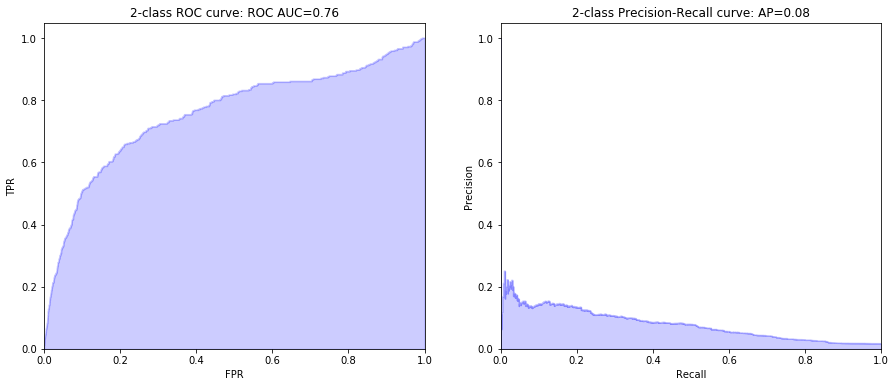

In [31]:
%%time 
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

prediction = model.predict(X_test)
prediction_proba = model.predict_proba(X_test)
plot_probas(prediction_proba)
#prediction = prediction_proba[:, 1] > prediction_proba[:, 1].mean()

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

## Imbalanced Learning 

### 1 Over-sampling
#### 1.1 Naive random over-sampling

In [32]:
from imblearn.over_sampling import RandomOverSampler

ROC AUC score: 0.8314
PR AUC score: 0.0924
CPU times: user 38 s, sys: 9.07 s, total: 47.1 s
Wall time: 31.2 s


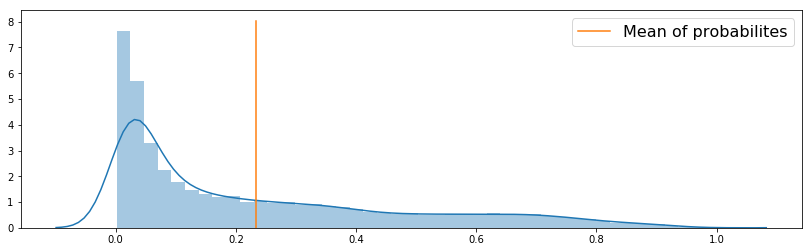

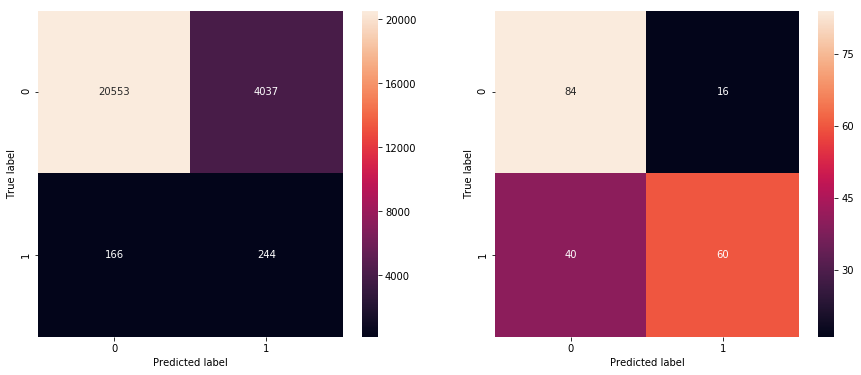

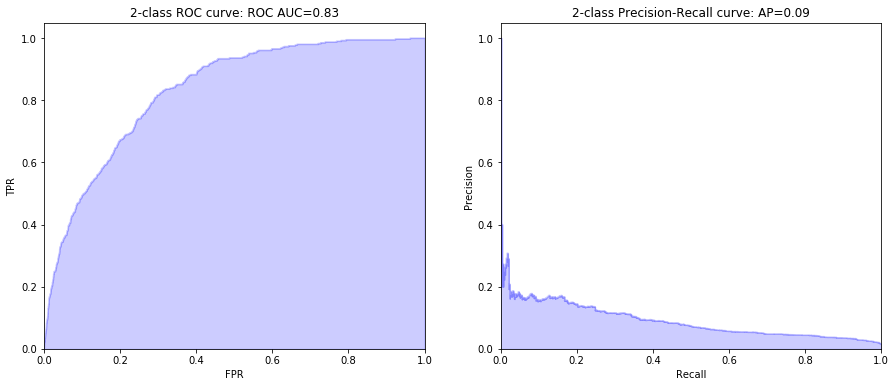

In [33]:
%%time 
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction = model.predict(X_test)
prediction_proba = model.predict_proba(X_test)
plot_probas(prediction_proba)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

ROC AUC score: 0.8396
PR AUC score: 0.0978
CPU times: user 20min 48s, sys: 16min 7s, total: 36min 56s
Wall time: 43min 4s


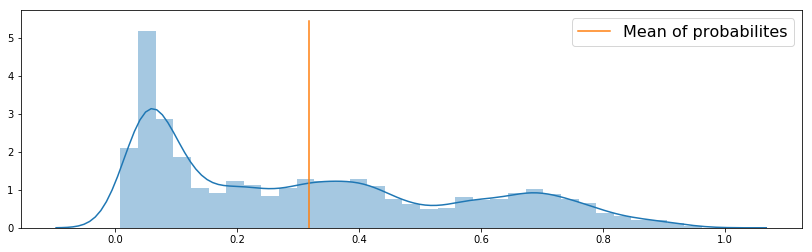

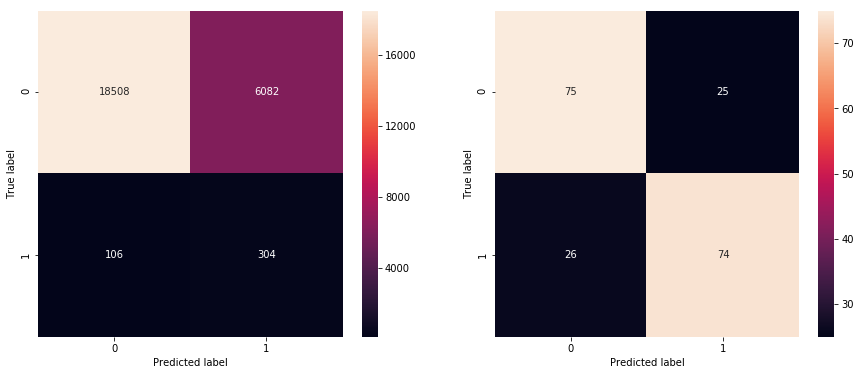

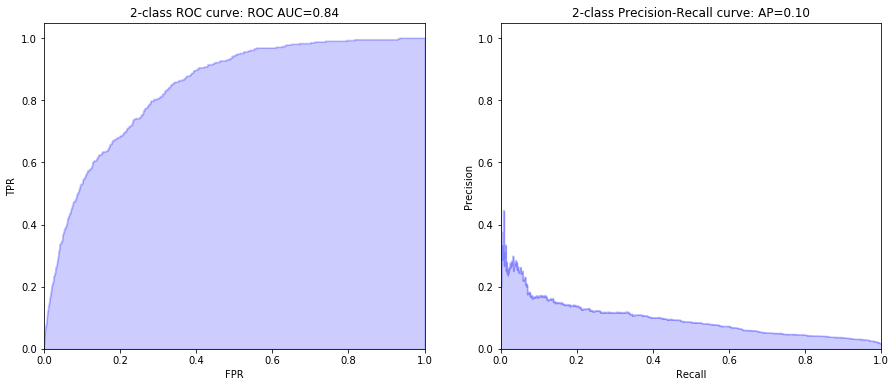

In [34]:
%%time 
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

model = XGBClassifier()
model.fit(X_resampled, y_resampled)

prediction = model.predict(X_test.values)
prediction_proba = model.predict_proba(X_test.values)
plot_probas(prediction_proba)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

#### 1.2  SMOTE: Synthetic Minority Oversampling Technique

In [35]:
from imblearn.over_sampling import SMOTE

ROC AUC score: 0.844
PR AUC score: 0.0961
CPU times: user 1min 16s, sys: 14 s, total: 1min 30s
Wall time: 53.5 s


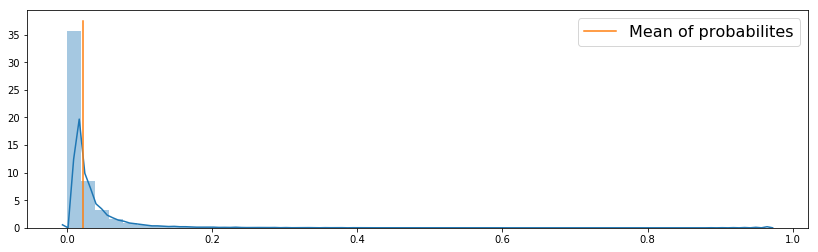

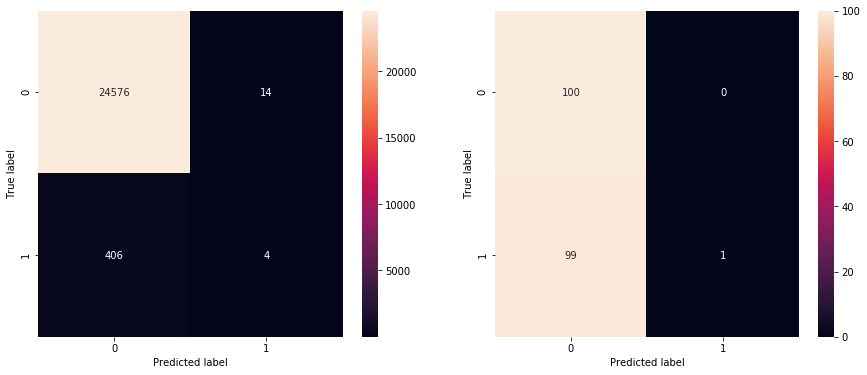

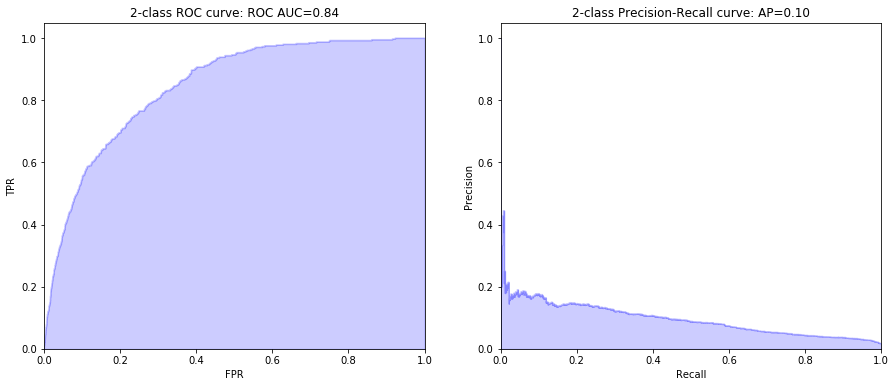

In [36]:
%%time 
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction = model.predict(X_test)
prediction_proba = model.predict_proba(X_test)
plot_probas(prediction_proba)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

ROC AUC score: 0.8037
PR AUC score: 0.0656
CPU times: user 21min 20s, sys: 16min 24s, total: 37min 45s
Wall time: 43min 55s


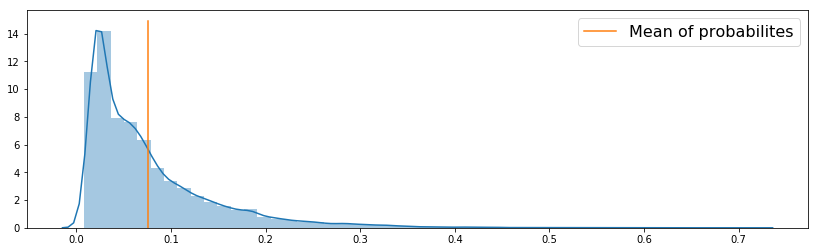

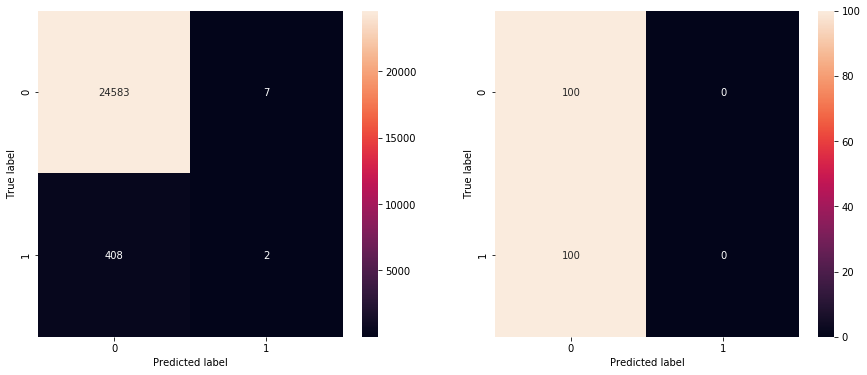

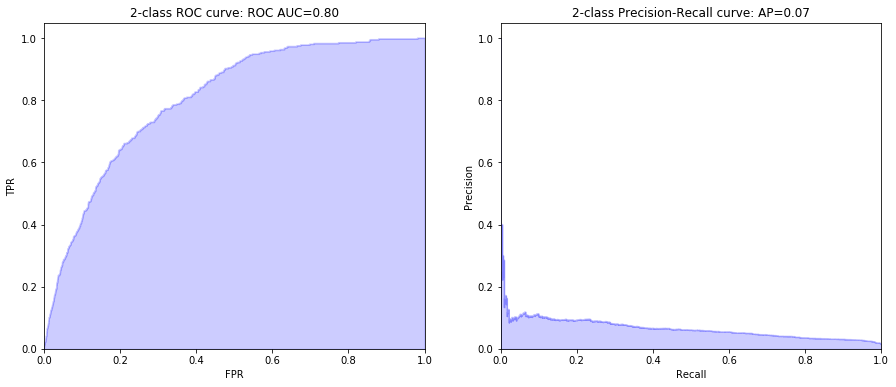

In [37]:
%%time 
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)

model = XGBClassifier()
model.fit(X_resampled, y_resampled)

prediction = model.predict(X_test.values)
prediction_proba = model.predict_proba(X_test.values)
plot_probas(prediction_proba)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

#### 1.3 ADASYN: Adaptive Synthetic sampling method

In [38]:
from imblearn.over_sampling import ADASYN

ROC AUC score: 0.8455
PR AUC score: 0.0985
CPU times: user 2min 1s, sys: 19.1 s, total: 2min 21s
Wall time: 1min 46s


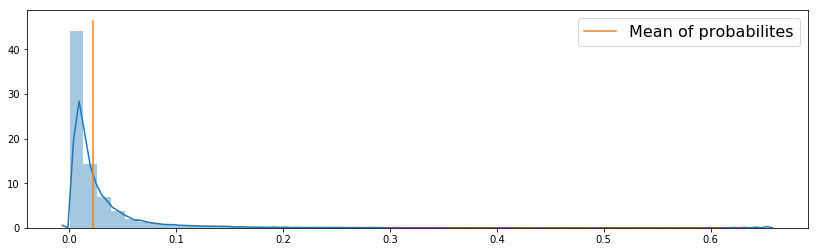

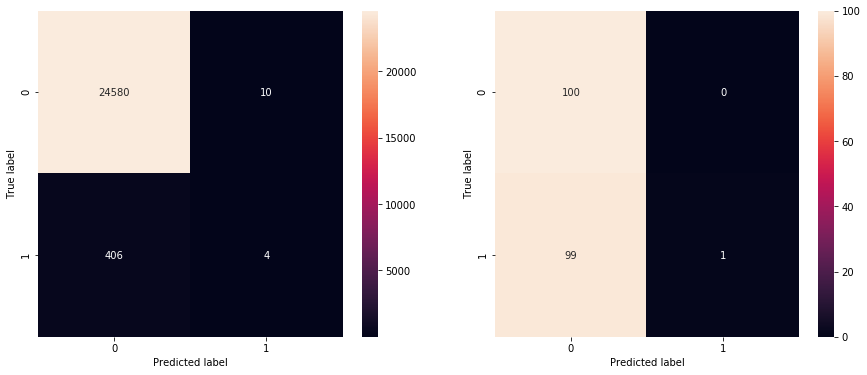

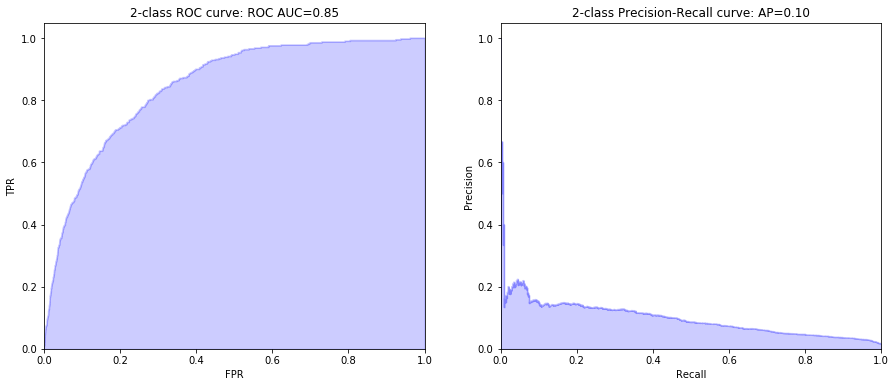

In [39]:
%%time 
X_resampled, y_resampled = ADASYN().fit_sample(X_train, y_train)

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction = model.predict(X_test)
prediction_proba = model.predict_proba(X_test)
plot_probas(prediction_proba)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

ROC AUC score: 0.7985
PR AUC score: 0.0612
CPU times: user 21min 35s, sys: 15min 25s, total: 37min
Wall time: 42min 28s


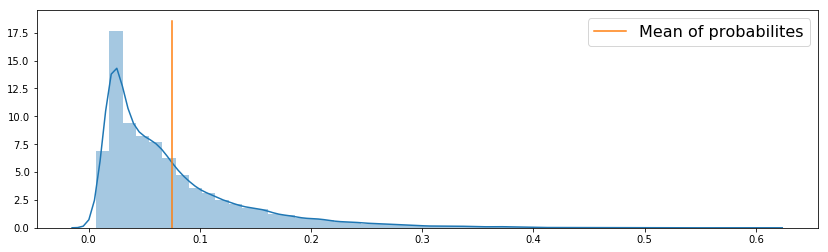

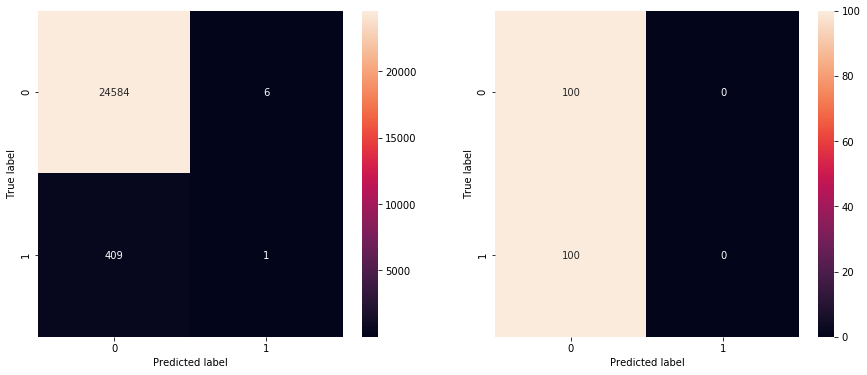

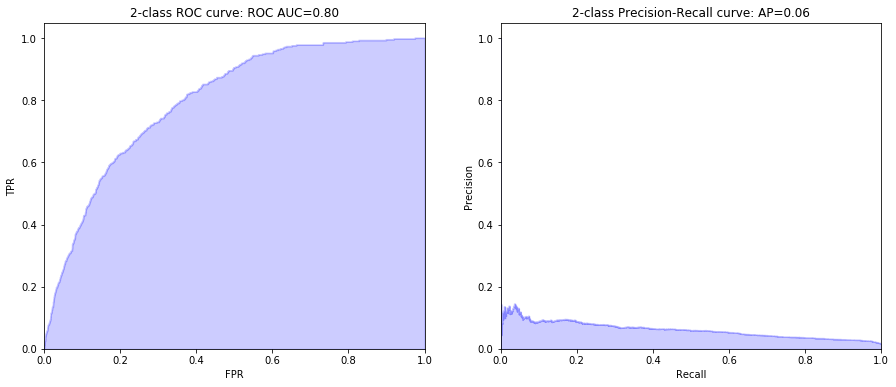

In [40]:
%%time 
X_resampled, y_resampled = ADASYN().fit_sample(X_train, y_train)

model = XGBClassifier()
model.fit(X_resampled, y_resampled)

prediction = model.predict(X_test.values)
prediction_proba = model.predict_proba(X_test.values)
plot_probas(prediction_proba)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

### 2 Under-sampling
#### 2.1  Controlled under-sampling techniques

In [41]:
from imblearn.under_sampling import RandomUnderSampler

In [42]:
X_resampled, y_resampled = RandomUnderSampler(random_state=0).fit_sample(X_train, y_train)

ROC AUC score: 0.832
PR AUC score: 0.0794
CPU times: user 7.95 s, sys: 3.21 s, total: 11.2 s
Wall time: 9.73 s


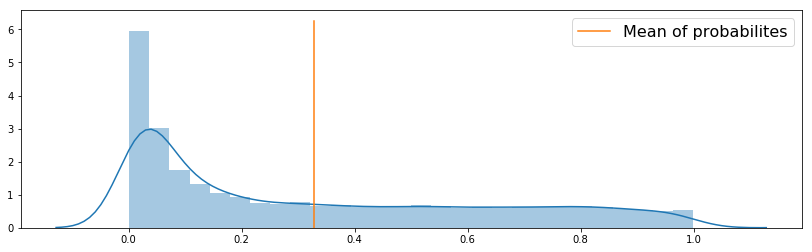

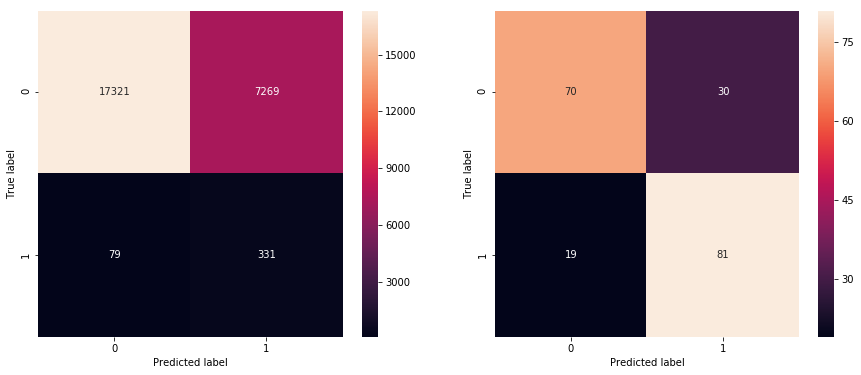

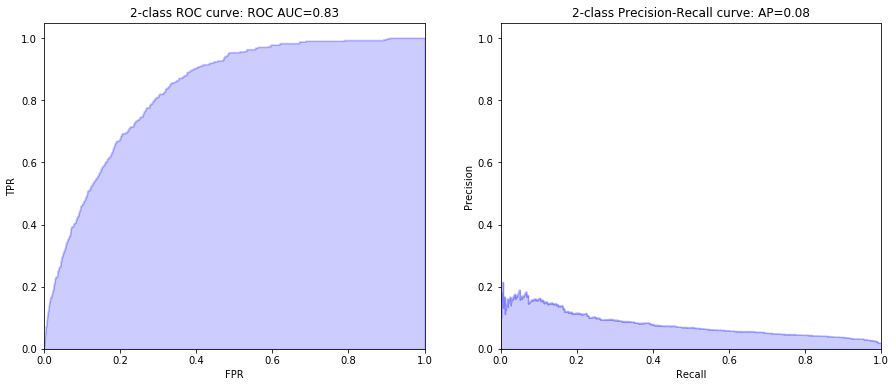

In [43]:
%%time 

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction = model.predict(X_test)
prediction_proba = model.predict_proba(X_test)
plot_probas(prediction_proba)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

ROC AUC score: 0.8372
PR AUC score: 0.0931
CPU times: user 20.9 s, sys: 1.32 s, total: 22.2 s
Wall time: 22.3 s


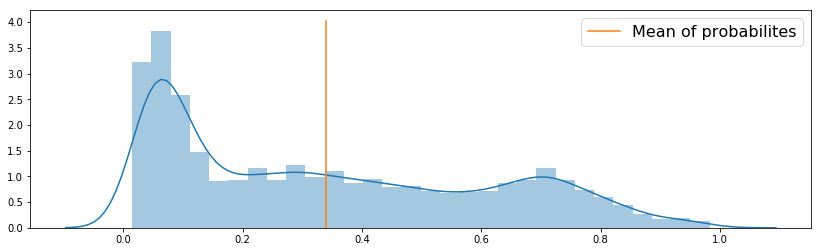

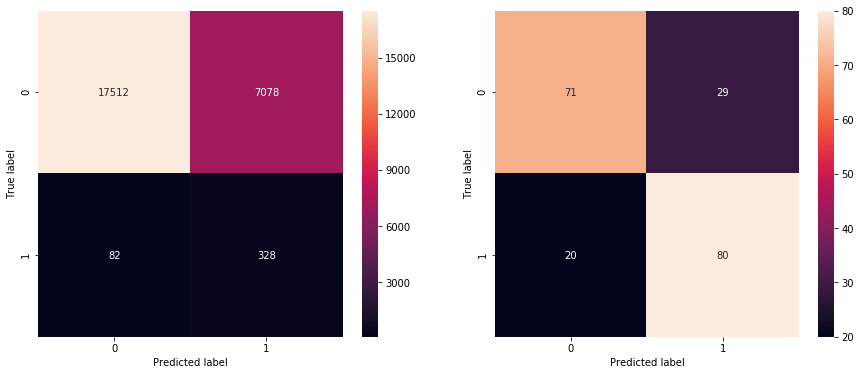

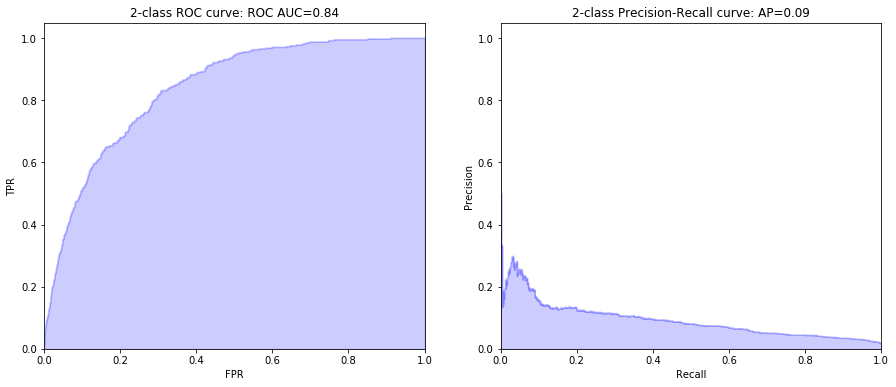

In [44]:
%%time 

model = XGBClassifier()
model.fit(X_resampled, y_resampled)

prediction = model.predict(X_test.values)
prediction_proba = model.predict_proba(X_test.values)
plot_probas(prediction_proba)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

#### 2.2 Cleaning under-sampling techniques

In [45]:
from imblearn.under_sampling import EditedNearestNeighbours

In [46]:
X_resampled, y_resampled = EditedNearestNeighbours(random_state=0).fit_sample(X_train, y_train)

ROC AUC score: 0.8454
PR AUC score: 0.0974
CPU times: user 15.7 s, sys: 3.06 s, total: 18.8 s
Wall time: 11.8 s


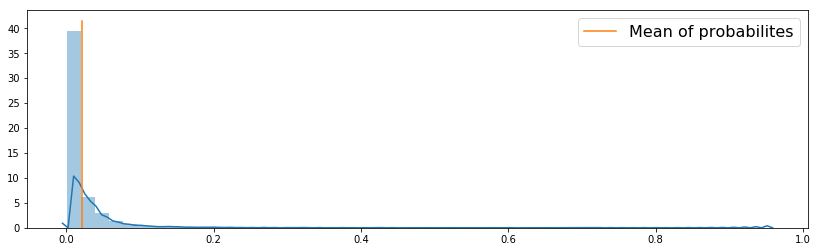

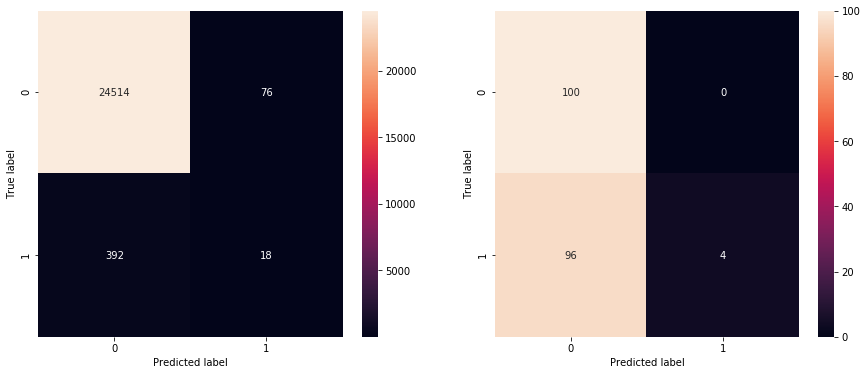

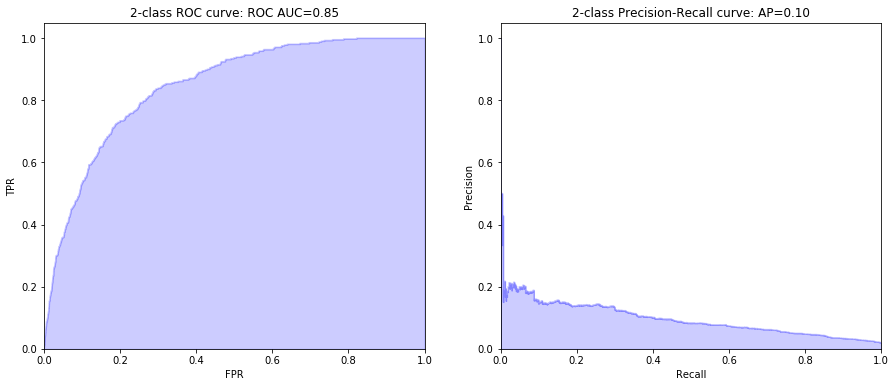

In [47]:
%%time 

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction = model.predict(X_test)
prediction_proba = model.predict_proba(X_test)
plot_probas(prediction_proba)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

ROC AUC score: 0.8424
PR AUC score: 0.1115
CPU times: user 7min 21s, sys: 6.99 s, total: 7min 28s
Wall time: 7min 29s


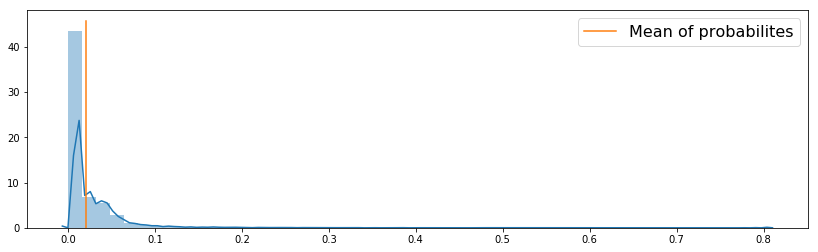

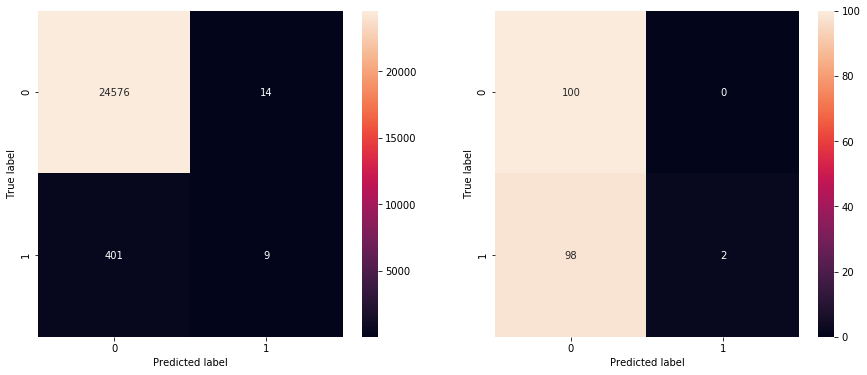

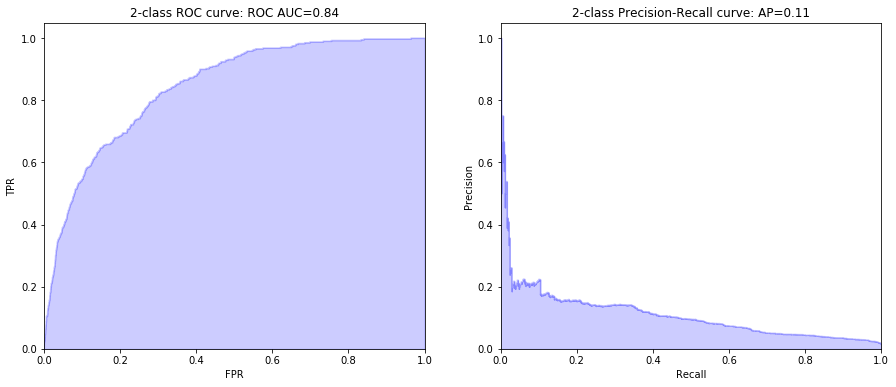

In [48]:
%%time 

model = XGBClassifier()
model.fit(X_resampled, y_resampled)

prediction = model.predict(X_test.values)
prediction_proba = model.predict_proba(X_test.values)
plot_probas(prediction_proba)
 
get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [49]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours

In [50]:
X_resampled, y_resampled = RepeatedEditedNearestNeighbours(random_state=0).fit_sample(X_train, y_train)

ROC AUC score: 0.8439
PR AUC score: 0.1019
CPU times: user 15.7 s, sys: 3.21 s, total: 18.9 s
Wall time: 11.8 s


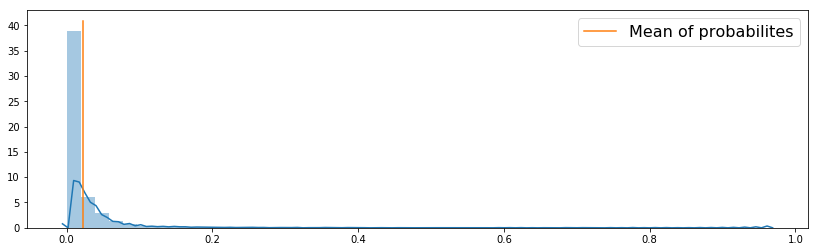

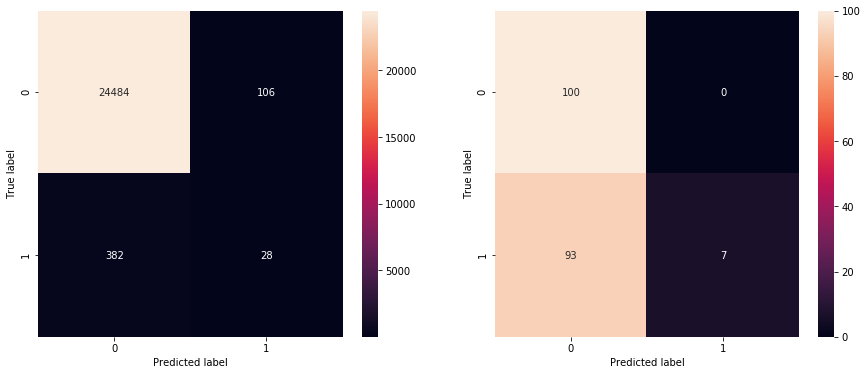

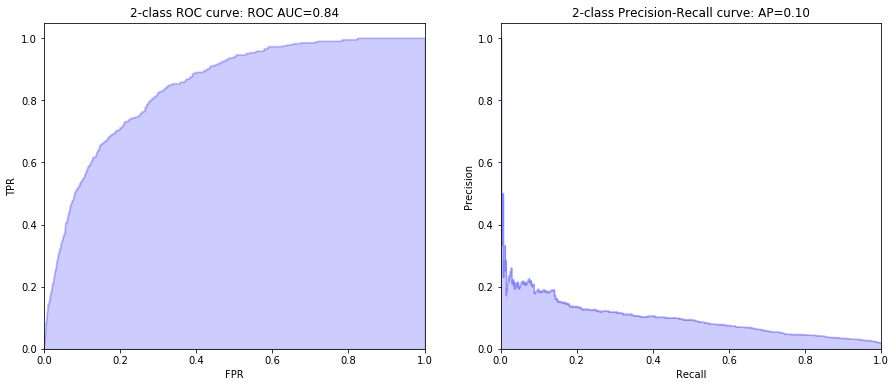

In [51]:
%%time 

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction = model.predict(X_test)
prediction_proba = model.predict_proba(X_test)
plot_probas(prediction_proba)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

ROC AUC score: 0.843
PR AUC score: 0.1054
CPU times: user 7min 11s, sys: 5.65 s, total: 7min 17s
Wall time: 7min 17s


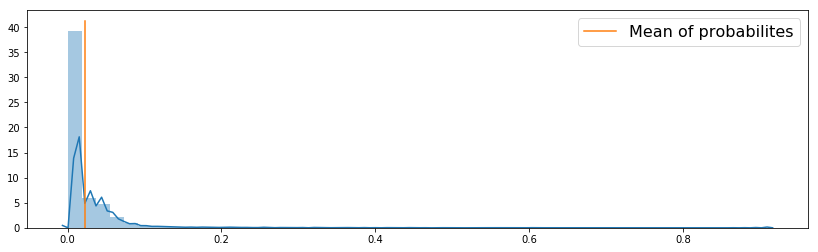

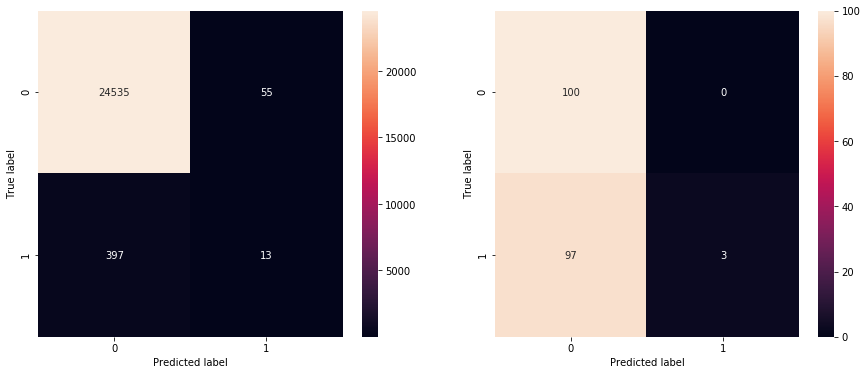

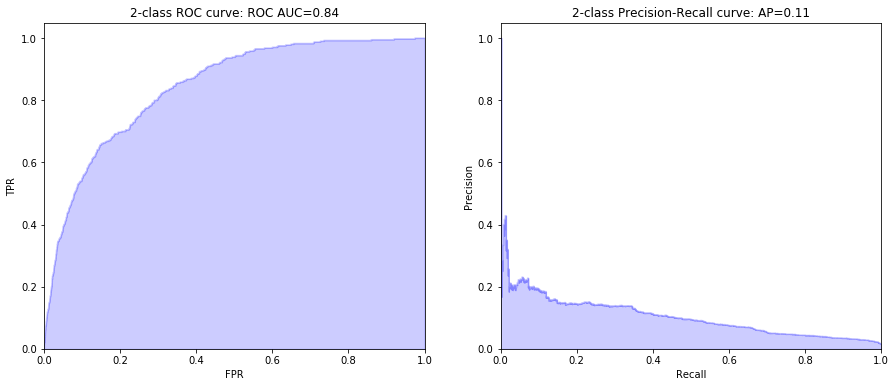

In [52]:
%%time 

model = XGBClassifier()
model.fit(X_resampled, y_resampled)

prediction = model.predict(X_test.values)
prediction_proba = model.predict_proba(X_test.values)
plot_probas(prediction_proba)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [53]:
from imblearn.under_sampling import AllKNN

In [54]:
X_resampled, y_resampled = AllKNN(random_state=0).fit_sample(X_train, y_train)

ROC AUC score: 0.8431
PR AUC score: 0.0951
CPU times: user 15.9 s, sys: 3.62 s, total: 19.6 s
Wall time: 12.9 s


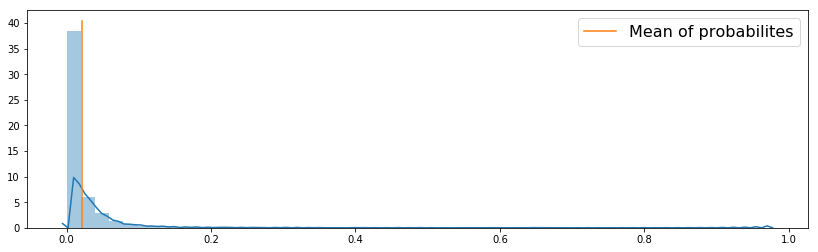

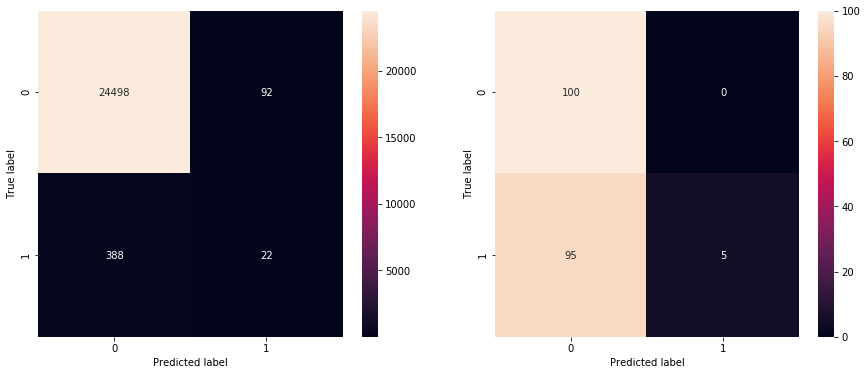

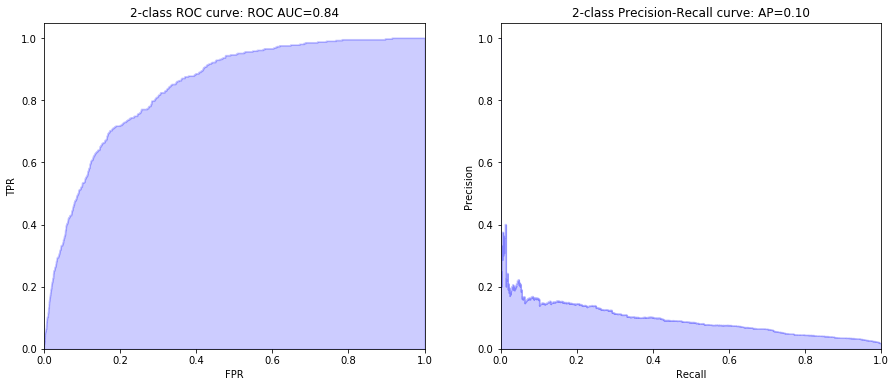

In [55]:
%%time 

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction = model.predict(X_test)
prediction_proba = model.predict_proba(X_test)
plot_probas(prediction_proba)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

ROC AUC score: 0.8408
PR AUC score: 0.1056
CPU times: user 7min 17s, sys: 5.77 s, total: 7min 23s
Wall time: 7min 24s


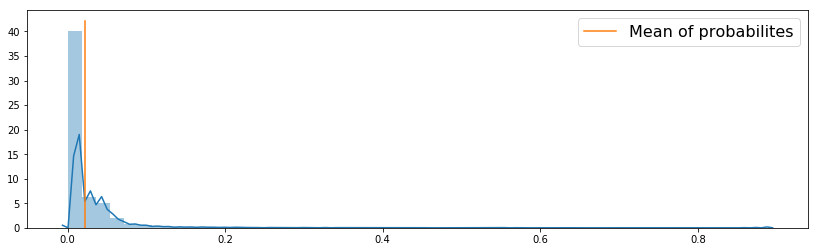

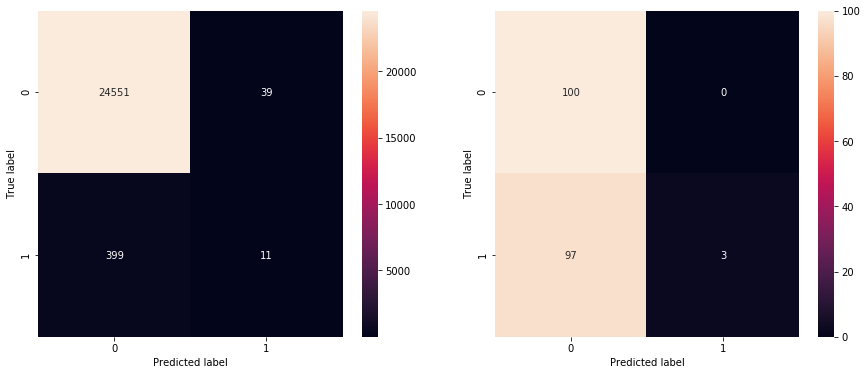

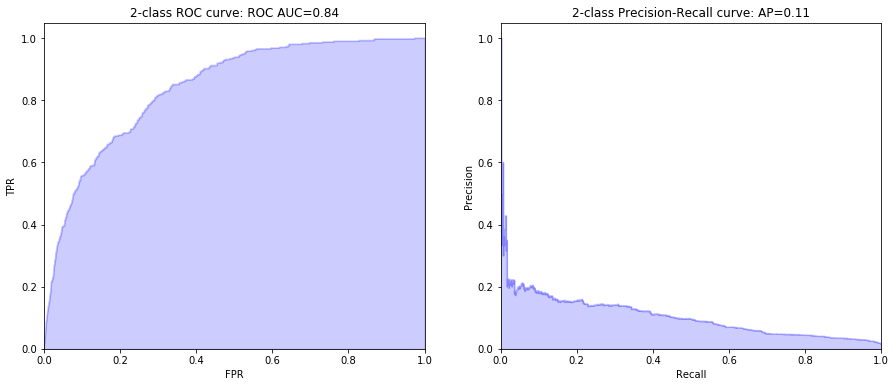

In [56]:
%%time 

model = XGBClassifier()
model.fit(X_resampled, y_resampled)

prediction = model.predict(X_test.values)
prediction_proba = model.predict_proba(X_test.values)
plot_probas(prediction_proba)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

#### 2.3  Instance hardness threshold

In [57]:
from imblearn.under_sampling import InstanceHardnessThreshold

In [58]:
iht = InstanceHardnessThreshold(random_state=0)
X_resampled, y_resampled = iht.fit_sample(X_train, y_train)

ROC AUC score: 0.8515
PR AUC score: 0.1011
CPU times: user 15 s, sys: 3.09 s, total: 18.1 s
Wall time: 11.7 s


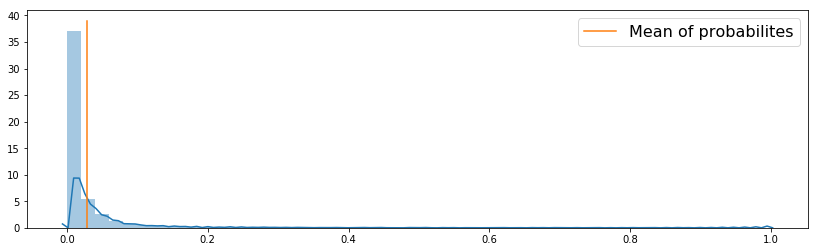

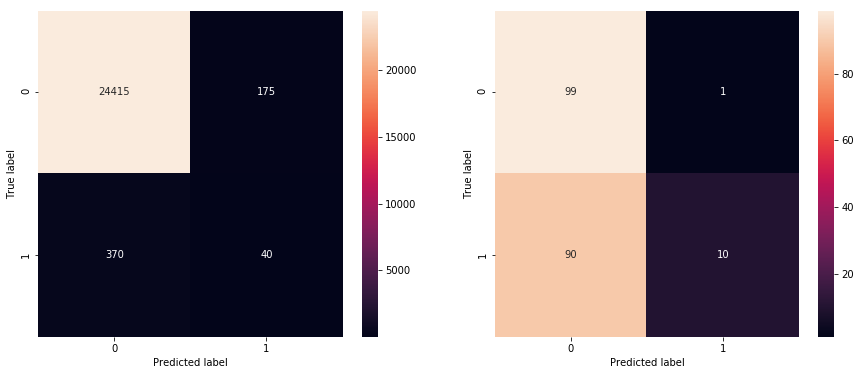

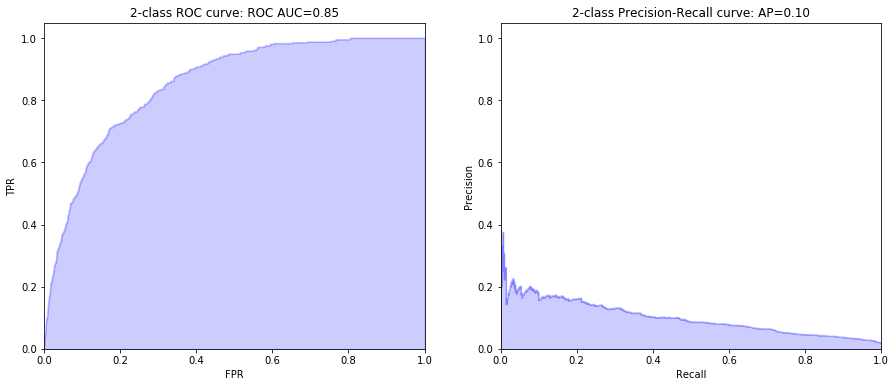

In [59]:
%%time 

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction = model.predict(X_test)
prediction_proba = model.predict_proba(X_test)
plot_probas(prediction_proba)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

ROC AUC score: 0.8437
PR AUC score: 0.1071
CPU times: user 6min 45s, sys: 4.17 s, total: 6min 49s
Wall time: 6min 50s


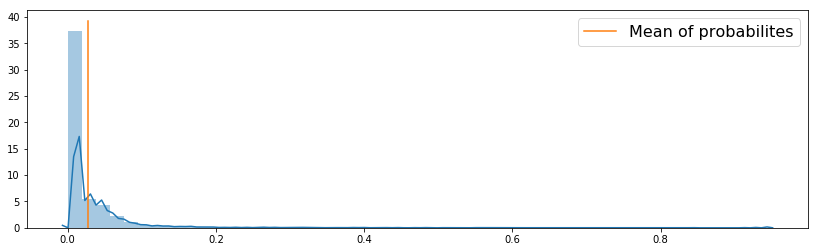

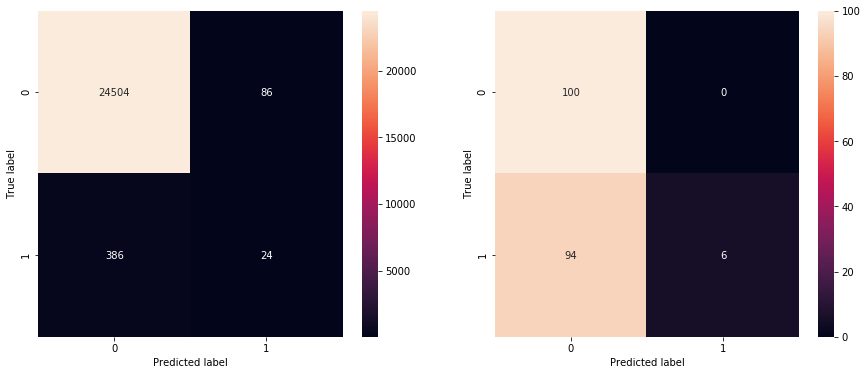

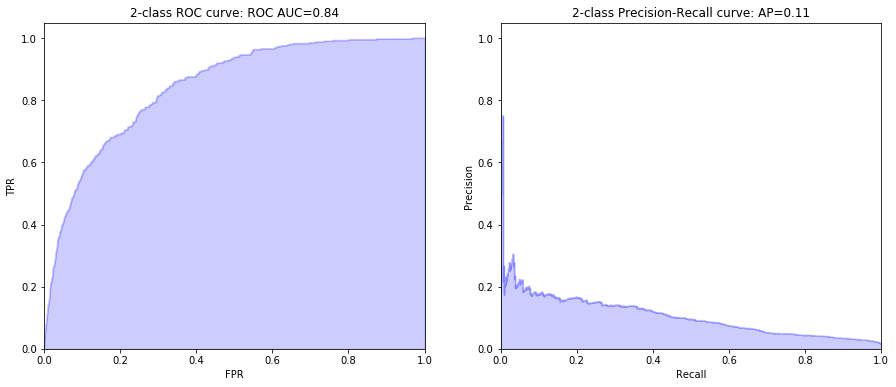

In [60]:
%%time 

model = XGBClassifier()
model.fit(X_resampled, y_resampled)

prediction = model.predict(X_test.values)
prediction_proba = model.predict_proba(X_test.values)
plot_probas(prediction_proba)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

### 3 Combination of over- and under-sampling

In [61]:
from imblearn.combine import SMOTEENN

In [62]:
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_sample(X_train, y_train)

ROC AUC score: 0.8485
PR AUC score: 0.1069
CPU times: user 59.3 s, sys: 5.62 s, total: 1min 4s
Wall time: 28.3 s


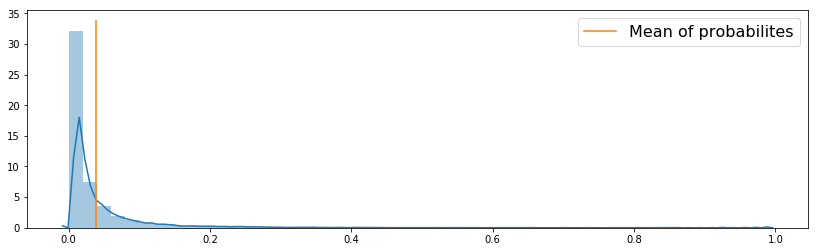

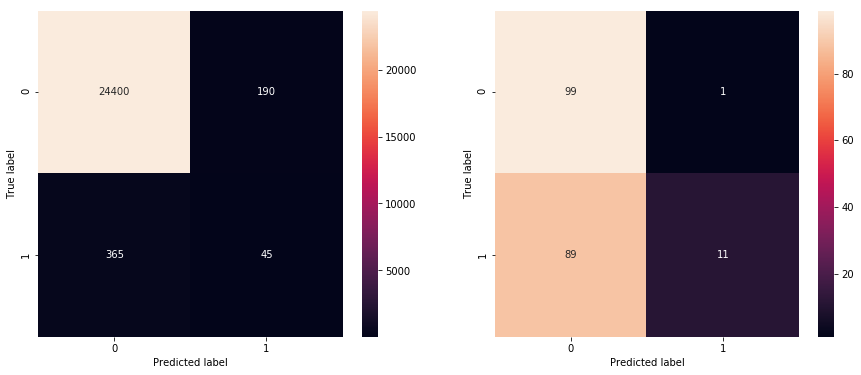

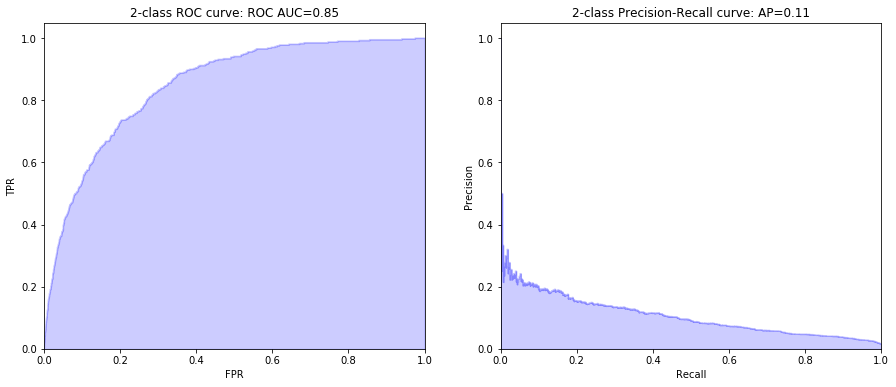

In [63]:
%%time 

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction = model.predict(X_test)
prediction_proba = model.predict_proba(X_test)
plot_probas(prediction_proba)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

ROC AUC score: 0.8165
PR AUC score: 0.0832
CPU times: user 17min 25s, sys: 10min 41s, total: 28min 7s
Wall time: 30min 14s


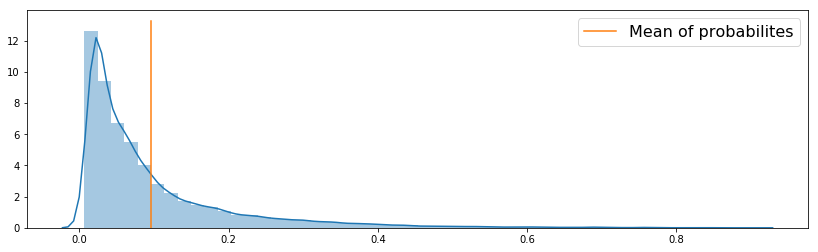

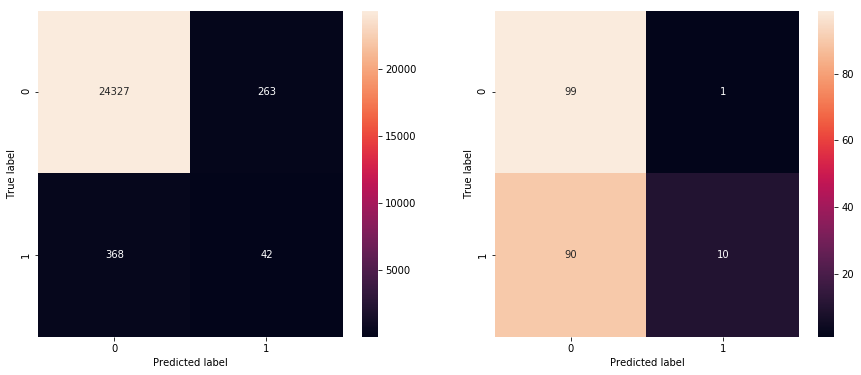

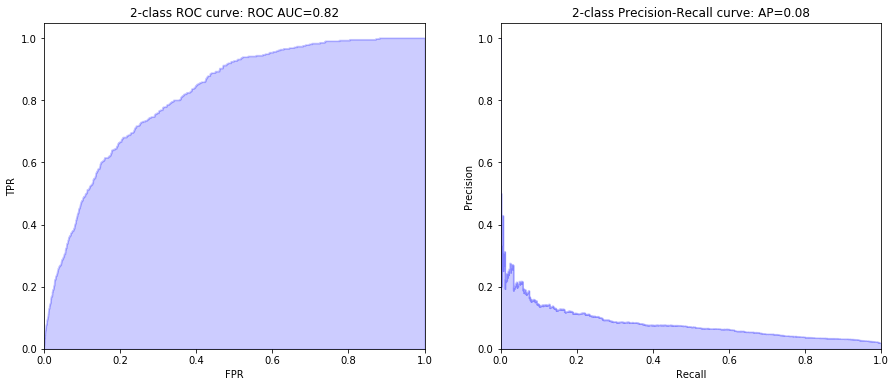

In [64]:
%%time 

model = XGBClassifier()
model.fit(X_resampled, y_resampled)

prediction = model.predict(X_test.values)
prediction_proba = model.predict_proba(X_test.values)
plot_probas(prediction_proba)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

### 4 Ensemble of samplers

In [65]:
from imblearn.ensemble import BalancedBaggingClassifier

ROC AUC score: 0.8446
PR AUC score: 0.1009
CPU times: user 4min 12s, sys: 1min 2s, total: 5min 14s
Wall time: 4min 57s


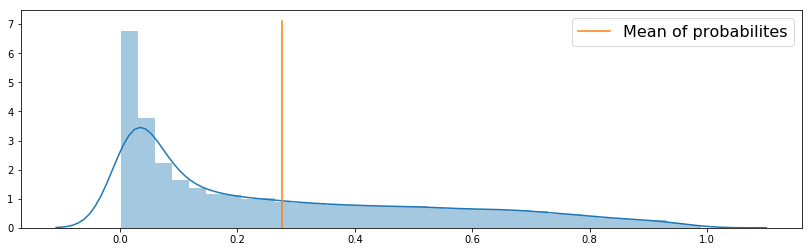

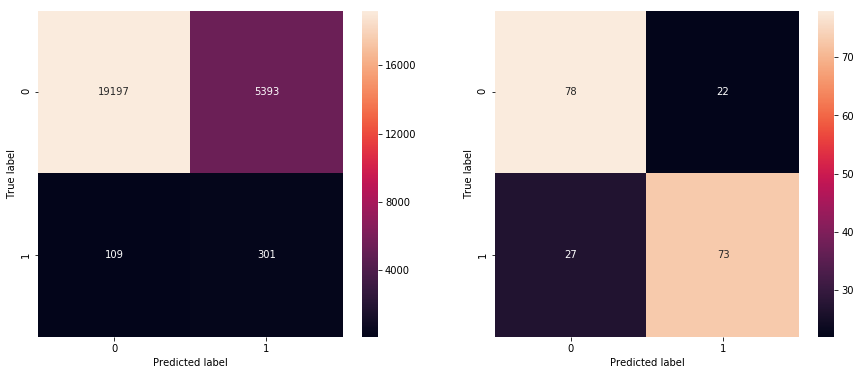

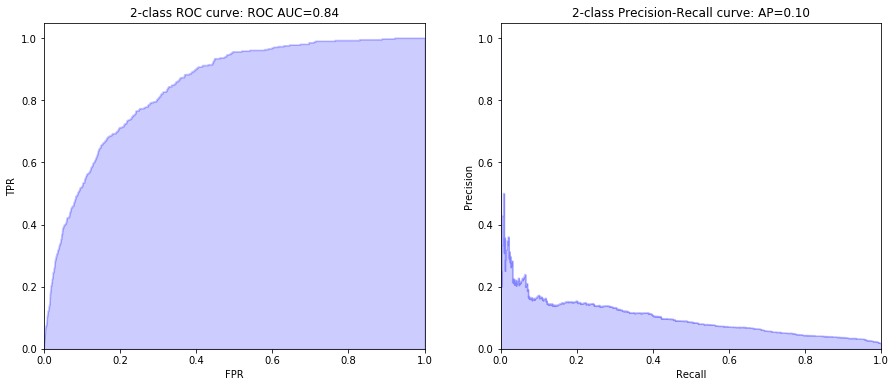

In [66]:
%%time 

model = BalancedBaggingClassifier(base_estimator=LGBMClassifier(),
                                 ratio='auto',
                                 replacement=False,
                                 random_state=0)
model.fit(X_train, y_train)

prediction = model.predict(X_test)
prediction_proba = model.predict_proba(X_test)
plot_probas(prediction_proba)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

ROC AUC score: 0.8434
PR AUC score: 0.1017
CPU times: user 6min 37s, sys: 55.3 s, total: 7min 32s
Wall time: 7min 37s


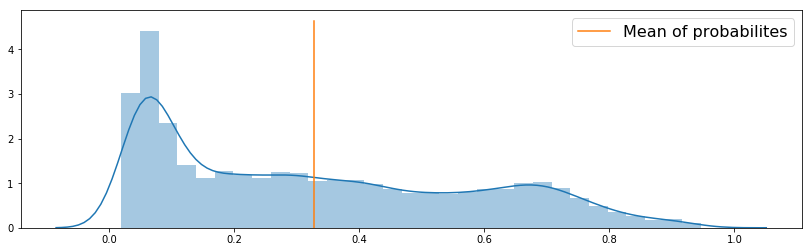

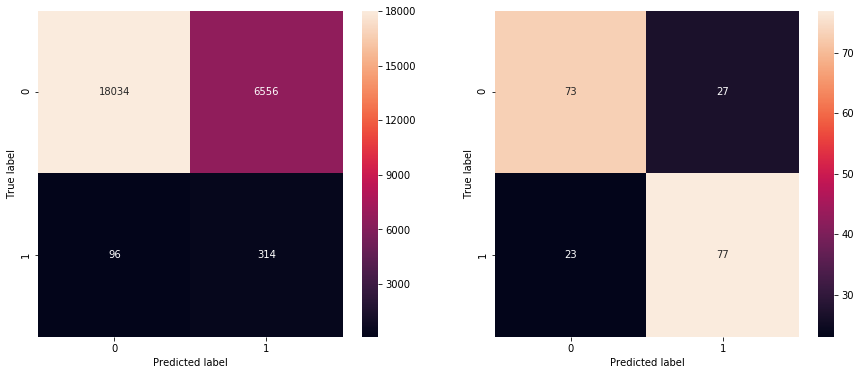

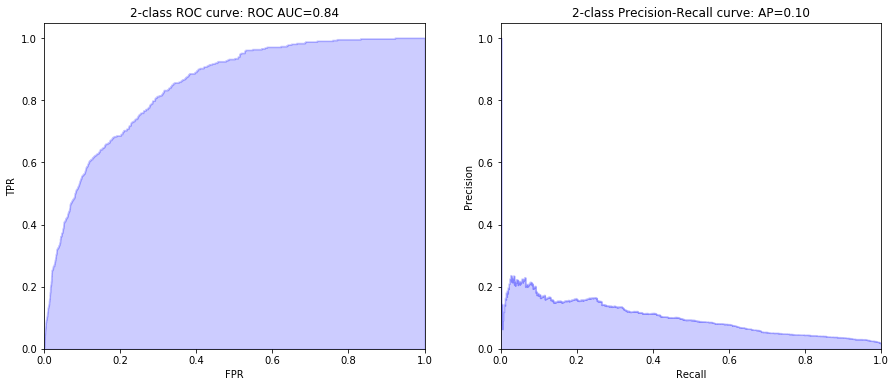

In [67]:
%%time 

model = BalancedBaggingClassifier(base_estimator=XGBClassifier(),
                                 ratio='auto',
                                 replacement=False,
                                 random_state=0)
model.fit(X_train, y_train)

prediction = model.predict(X_test)
prediction_proba = model.predict_proba(X_test)
plot_probas(prediction_proba)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

## Balancing data

w =  15
ROC AUC score: 0.8419
PR AUC score: 0.0983
w =  20
ROC AUC score: 0.8382
PR AUC score: 0.0936
w =  25
ROC AUC score: 0.8364
PR AUC score: 0.0989
w =  30
ROC AUC score: 0.8381
PR AUC score: 0.096
w =  35
ROC AUC score: 0.8361
PR AUC score: 0.0965
w =  40
ROC AUC score: 0.8381
PR AUC score: 0.0955
w =  45
ROC AUC score: 0.8339
PR AUC score: 0.0978
w =  50
ROC AUC score: 0.8298
PR AUC score: 0.093


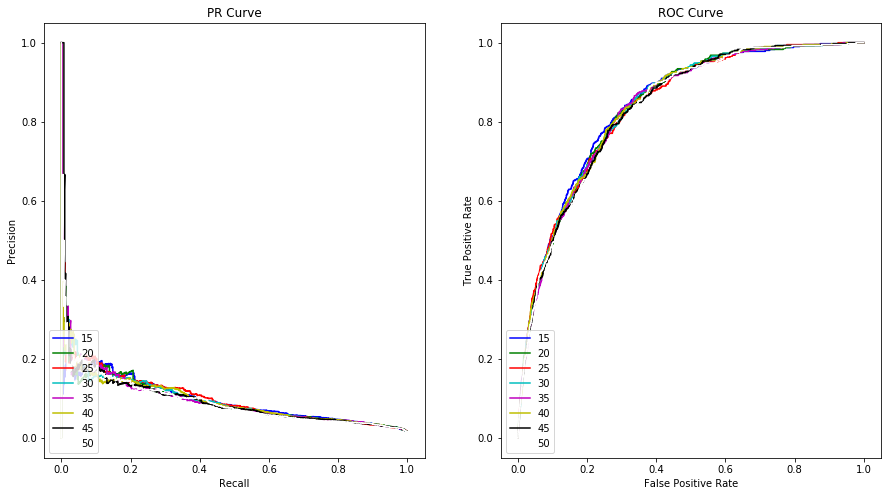

In [68]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for w,k in zip(np.arange(15, 200, 5),'bgrcmykw'):
    lr_model = LGBMClassifier(class_weight={0:1,1:w})
    lr_model.fit(X_train,y_train)
    pred_prob = lr_model.predict_proba(X_test)[:,1]
    print('w = ', w) 
    get_roc_auc_score(lr_model.predict_proba(X_test), y_test)
    get_pr_auc_score (lr_model.predict_proba(X_test), y_test)
    
    p,r,_ = precision_recall_curve(y_test, pred_prob)
    tpr,fpr,_ = roc_curve(y_test, pred_prob)
    
    ax1.plot(r,p,c=k,label=w)
    ax2.plot(tpr,fpr,c=k,label=w)
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')

plt.show()